In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib.pyplot as plt

## CARGAMOS LOS PARAMETROS

In [ ]:
#load data
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/kdm-database-spiners

Dataset URL: https://www.kaggle.com/datasets/deathperminut/kdm-database-spiners
License(s): CC0-1.0
 99% 396M/400M [00:00<00:00, 1.38GB/s]
100% 400M/400M [00:00<00:00, 1.38GB/s]


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/kdm-database-spiners.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['data.npy.npz']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
MS,Nest,L,rd,So,T,Jex,Jex2,Jex3,Jex4,Kan1,KanS,Hex,kd,KDM = data['MS'],data['Nest'],data['L'],data['rd'],data['So'],data['T'],data['Jex'],data['Jex2'],data['Jex3'],data['Jex4'],data['Kan1'],data['KanS'],data['Hex'],data['kd'],data['KDM']

In [ ]:
MS.shape

(164212, 39, 39, 1)

In [ ]:
KDM.shape

(164212,)

(array([15814., 15475., 16952., 16522., 16374., 16032., 17000., 17041.,
        16776., 16226.]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ]),
 <BarContainer object of 10 artists>)

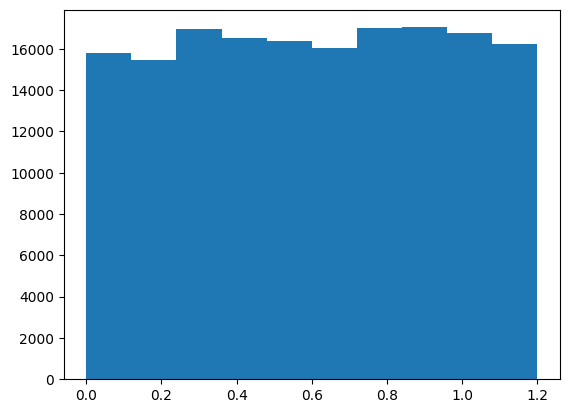

In [ ]:
plt.hist(KDM)  ## LISTADO DE VARIABLES KDM,T,Nest,Kan1,KanS,Hex

## HISTOGRAMA DE LOS PARAMETROS DE BUSQUEDA

In [ ]:
# Calcular el mínimo y máximo global de las imágenes
global_vmin = np.min([np.min(img) for img in MS])
global_vmax = np.max([np.max(img) for img in MS])

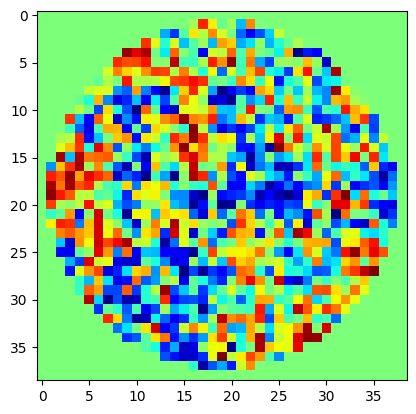

In [ ]:
plt.imshow(MS[0,:,:],cmap='jet',vmin=global_vmin,vmax=global_vmax)

## SACAMOS UNA MUESTRA DE TODAS LAS IMAGENES ALREDEDOR DE 60000 PARA PODER TRABAJAR COMO VENIAMOS HACIENDOLO

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Combinar las 6 variables en una sola matriz (164212, 6)
Y = np.stack([data['KDM'], data['T'], data['Nest'], data['Kan1'], data['KanS'], data['Hex']], axis=1)

# Estandarizar (opcional pero recomendado para clustering)
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)


In [ ]:
from sklearn.cluster import KMeans

# Decidir el número de grupos para balancear (por ejemplo, 100 grupos)
k = 100
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(Y_scaled)


In [ ]:
from collections import defaultdict

# Asociar cada índice a su cluster
cluster_to_indices = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_to_indices[label].append(idx)

# Ahora extraemos muestras balanceadas de cada cluster
samples_per_cluster = 60000 // k
selected_indices = []

np.random.seed(42)  # Para reproducibilidad

for indices in cluster_to_indices.values():
    if len(indices) >= samples_per_cluster:
        sampled = np.random.choice(indices, samples_per_cluster, replace=False)
    else:
        # Si hay menos de lo necesario, puedes tomar todos o hacer oversampling si lo deseas
        sampled = np.random.choice(indices, samples_per_cluster, replace=True)
    selected_indices.extend(sampled)

selected_indices = np.array(selected_indices)


In [ ]:
# Extraer datos balanceados
MS_sampled = data['MS'][selected_indices]
params_sampled = {
    'KDM': data['KDM'][selected_indices],
    'T': data['T'][selected_indices],
    'Nest': data['Nest'][selected_indices],
    'Kan1': data['Kan1'][selected_indices],
    'KanS': data['KanS'][selected_indices],
    'Hex': data['Hex'][selected_indices]
}


In [ ]:
MS_sampled.shape

(60000, 39, 39, 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(array([5068., 6241., 6133., 5866., 6170., 5887., 5742., 5802., 6094.,
        6997.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 ]),
 <BarContainer object of 10 artists>)

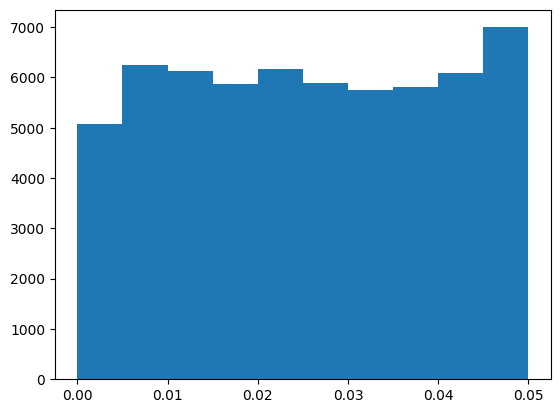

In [ ]:
plt.hist(params_sampled['Hex'])

## LLEVAMOS LAS IMAGENES A LA NUEVA DIMENSIÓN

In [ ]:
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))  # Redimensionar
    image = tf.image.grayscale_to_rgb(image)  # Convertir a 3 canales
    return image
# Crear dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(MS_sampled)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Convertir a un array numpy si es necesario
processed_images = np.array(list(dataset.as_numpy_iterator()))

In [ ]:
np.savez_compressed("/content/drive/MyDrive/imagenes_comprimidasBASE_KDM.npz", data=processed_images)

In [ ]:
Y = np.stack([
    params_sampled['KDM'],
    params_sampled['T'],
    params_sampled['Nest'], # NUMERO DE ESTADO
    params_sampled['Kan1'], # CONSTANTE DE ANISOTROPIA
    params_sampled['KanS'], # CONSTANTE DE ANISOTROPIA DE SUPERFICIE
    params_sampled['Hex'] #  CAMPO EXTERNO.
], axis=1)  # Shape final: (60000, 6)

In [ ]:
Y

array([[5.20e-01, 1.17e+01, 8.56e+02, 9.00e-02, 1.57e-01, 3.00e-02],
       [8.60e-02, 1.62e+01, 1.48e+02, 6.10e-02, 9.50e-02, 3.60e-02],
       [5.14e-01, 1.27e+01, 3.00e+01, 1.24e-01, 1.50e-01, 4.40e-02],
       ...,
       [9.30e-02, 5.20e+00, 7.80e+01, 1.14e-01, 3.60e-02, 2.70e-02],
       [3.70e-01, 4.70e+00, 7.62e+02, 1.55e-01, 6.30e-02, 2.20e-02],
       [5.31e-01, 1.80e+00, 1.71e+02, 1.38e-01, 3.40e-02, 1.10e-02]])

In [ ]:
np.savez_compressed("/content/drive/MyDrive/outputsBASE_KDM.npz", data=Y)